
# Subset SWOT LR L3 Unsmoothed data via THREDDS Data Server
This notebooks explains how to retrieve a geographical subset of unsmoothed (250-m) SWOT LR L3 data on AVISO's THREDDS Data Server.

L3 Unsmoothed data can be explored at:

* https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-pre-validated/l3_lr_ssh/v1_0/Unsmoothed/catalog.html

You need to have xarray, numpy, pydap, threddsclient and matplotlib+cartopy (for visualisation) packages installed in your Python environment for this notebook to work.


## Tutorial Objectives
* Request Aviso's Thredds Data Server catalogue to find unsmoothed products
* Define a geographical area and temporal period to subset data
* Download data locally and visualise it



## Import + code



In [1]:
# Install Cartopy with mamba to avoid discrepancies
# ! mamba install -q -c conda-forge cartopy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
from getpass import getpass
import threddsclient
import numpy as np
import xarray as xr
from xarray.backends import PydapDataStore
import requests as rq
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [4]:
def retrieve_matching_datasets(url_catalogue, cycle_min, cycle_max, half_orbits):
    """ Returns the list of datasets available in the catalogue, matching required half_orbits and cycles range.
    Args:
        url_catalogue
        cycle_min
        cycle_max
        half_orbits

    Returns:
        The list of matching dataset nodes.
    """
    return list(filter(
        lambda dataset: (
            int(dataset.name[30:33]) in half_orbits and
            int(dataset.name[26:29]) >= cycle_min and
            int(dataset.name[26:29]) <= cycle_max),
        threddsclient.crawl(url_catalogue, depth=2)))

def open_dataset(dataset_url):
    """ Open the dataset at dataset_url.
    Args:
        dataset_url

    Returns:
        xr.Dataset
    """
    session = rq.Session()
    session.auth = (username, password)
    store = PydapDataStore.open(dataset_url, session=session, timeout=300, user_charset='UTF-8')
    return xr.open_dataset(store)

def _open_dataset_coords(dataset_url):
    positions_url = dataset_url + '?' + ','.join(["latitude", "longitude", "latitude", "longitude"])
    ds_coords = open_dataset(positions_url)
    return ds_coords

def _get_indexes(ds, lon_range, lat_range):
    mask_left = ((ds["longitude"] >= lon_range[0]) & (ds["longitude"] <= lon_range[1]) &
    (ds["latitude"] >= lat_range[0]) & (ds["latitude"] <= lat_range[1]))
            
    mask_right = ((ds["longitude"] >= lon_range[0]) & (ds["longitude"] <= lon_range[1]) & 
    (ds["latitude"] >= lat_range[0]) & (ds["latitude"] <= lat_range[1]))

    mask = (mask_left | mask_right).any('num_pixels')

    return np.where(mask)[0][0], np.where(mask)[0][-1]
    
def _output_dir_prompt():
    answer = input('Do you want to write results to Netcdf files? [y/n]')
    if not answer or answer[0].lower() != 'y':
        return None
    return input('Enter existing directory:')

def load_subsets(matching_datasets, variables, lon_range, lat_range, output_dir=None):
    """ Loads subsets with variables and lon/lat range, and eventually write them to disk.
    Args:
        matching_datasets : the datasets nodes in the catalogue
        variables : the variables names
        lon_range : the longitude range
        lat_range : the latitude range
        output_dir : the output directory to write the datasets in separated netcdf files

    Returns:
        xr.Dataset
    """
    if not output_dir:
        output_dir = _output_dir_prompt()
    return [dataset for dataset in [_load_subset(dataset, variables, lon_range, lat_range, output_dir) for dataset in matching_datasets] if dataset is not None]
    
def _load_subset(dataset_node, variables, lon_range, lat_range, output_dir=None):
    if output_dir:
        output_file = os.path.join(output_dir, f"subset_{dataset_node.name}")
        if os.path.exists(output_file):
            print(f"Subset {dataset_node.name} already exists. Reading it...")
            return xr.open_dataset(output_file)
        
    # Open the dataset only with coordinates
    dataset_url = dataset_node.opendap_url()
    ds_positions = _open_dataset_coords(dataset_url)

    # Locate indexes of lines matching with the required geographical area
    try:
        idx_first, idx_last = _get_indexes(ds_positions, lon_range, lat_range)
    except IndexError:
        print(f'No pass intersection with selected area for dataset {dataset_node.name}')
        return None
        
    print(f"Indices for dataset {dataset_node.name}: ({idx_first}, {idx_last})")

    # Download subset    
    dataset = open_dataset(dataset_url)
        
    ds = xr.merge([dataset[var][idx_first:idx_last] for var in variables])
    ds.load()
    print(f"{dataset_node.name} subset loaded.")

    if output_file:
        ds.to_netcdf(output_file)
        print(f"{output_file} created.")
        
    return ds

## Parameters



### Data parameters
Variables available in unsmoothed Swot LR L3 data are:

time, calibration, dac, mdt, mss, ocean_tide, quality_flag, sigma0, ssha, ssha_noiseless, ssha_unedited, ugos, ugosa, vgos, vgosa

Define the variables you want:



In [5]:
variables = ['time', 'ssha_noiseless']

*OPTIONAL*
Define **existing** output folder to save results:



In [6]:
output_dir = "downloads"#or None

Define the parameters needed to retrieve data:

* geographical area
* phase: 1day-orbit (Calval) / 21day-orbit (Science)
* cycle min, max
* list of half-orbits

<div class="alert alert-info"><b>Note</b><p>Passes matching a geographical area and period can be found using <a href="https://mybinder.org/v2/gh/CNES/search_swot/HEAD?urlpath=voila%2Frender%2Fmain.ipynb">Search Swot tool</a></p></div>




In [7]:
# California
lat_range = 35, 42
lon_range = 233, 239

#phase, cycle_min, cycle_max = "calval", 400, 600
phase, cycle_min, cycle_max = "calval", 560, 570

url_catalogue="https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-pre-validated/l3_lr_ssh/v1_0/Unsmoothed/catalog.html"
half_orbits = [13]

### Authentication parameters
Enter your AVISO+ credentials



In [ ]:
username = input("Enter username:")

In [ ]:
password = getpass(f"Enter password for {username}:")

## Area extraction
Gather datasets in the provided catalogue, matching the required cycles and half_orbits



In [9]:
matching_datasets = retrieve_matching_datasets(url_catalogue, cycle_min, cycle_max, half_orbits)
'num datasets =', len(matching_datasets)

('num datasets =', 11)

In [10]:
matching_datasets

[<Node name: SWOT_L3_LR_SSH_Unsmoothed_570_013_20230702T171547_20230702T180653_v1.0.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_569_013_20230701T172509_20230701T181615_v1.0.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_568_013_20230630T173521_20230630T182426_v1.0.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_567_013_20230629T174353_20230629T183459_v1.0.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_566_013_20230628T175316_20230628T184421_v1.0.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_565_013_20230627T180238_20230627T185344_v1.0.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_564_013_20230626T181200_20230626T190306_v1.0.nc, content type: application/netcdf>,
 <Node name: SWOT_L3_LR_SSH_Unsmoothed_563_013_20230625T182122_20230625T191228_v1.0.nc, content type: application/netcdf>,
 <Node name: SWO

### Subset data in the required geographical area



<div class="alert alert-warning"><b>Warning</b><p>
 This operation takes some time : for each dataset, it downloads coordinates, calculates indices, loads subset and eventually writes it to netcdf file.</p></div>

Set ``output_dir`` to ``None`` if you don't want to write subsets in netcdf files.



In [11]:
datasets_subsets = load_subsets(matching_datasets, variables, lon_range, lat_range, output_dir)

Indices for dataset SWOT_L3_LR_SSH_Unsmoothed_570_013_20230702T171547_20230702T180653_v1.0.nc: (57392, 60858)
SWOT_L3_LR_SSH_Unsmoothed_570_013_20230702T171547_20230702T180653_v1.0.nc subset loaded.
downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_570_013_20230702T171547_20230702T180653_v1.0.nc created.
Indices for dataset SWOT_L3_LR_SSH_Unsmoothed_569_013_20230701T172509_20230701T181615_v1.0.nc: (57390, 60857)
SWOT_L3_LR_SSH_Unsmoothed_569_013_20230701T172509_20230701T181615_v1.0.nc subset loaded.
downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_569_013_20230701T172509_20230701T181615_v1.0.nc created.
No pass intersection with selected area for dataset SWOT_L3_LR_SSH_Unsmoothed_568_013_20230630T173521_20230630T182426_v1.0.nc
Indices for dataset SWOT_L3_LR_SSH_Unsmoothed_567_013_20230629T174353_20230629T183459_v1.0.nc: (57387, 60854)
SWOT_L3_LR_SSH_Unsmoothed_567_013_20230629T174353_20230629T183459_v1.0.nc subset loaded.
downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_567_013_20230629T174353_20230629T1

## Basic manipulations



### Concatenate subsets



In [12]:
ds = xr.concat(datasets_subsets, dim='num_lines')
ds

<xarray.Dataset>
Dimensions:         (num_lines: 34666, num_pixels: 519)
Coordinates:
    latitude        (num_lines, num_pixels) float64 35.0 35.0 35.0 ... 42.0 42.0
    longitude       (num_lines, num_pixels) float64 233.7 233.7 ... 237.2 237.2
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time            (num_lines) datetime64[ns] 2023-07-02T17:51:29.931714304 ...
    ssha_noiseless  (num_lines, num_pixels) float64 nan nan nan ... nan nan nan
Attributes:
    comment:             Time of measurement in seconds in the UTC time scale...
    leap_second:         0000-00-00T00:00:00Z
    long_name:           time in UTC
    standard_name:       time
    tai_utc_difference:  37.0
    _ChunkSizes:         82254

### Visualize data on a pass



Open a pass dataset



In [13]:
subset_file = "downloads/subset_SWOT_L3_LR_SSH_Unsmoothed_560_013_20230622T184928_20230622T194034_v1.0.nc"

In [14]:
ds = xr.open_dataset(subset_file)

In [15]:
ds

<xarray.Dataset>
Dimensions:         (num_lines: 3467, num_pixels: 519)
Coordinates:
    latitude        (num_lines, num_pixels) float64 ...
    longitude       (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time            (num_lines) datetime64[ns] ...
    ssha_noiseless  (num_lines, num_pixels) float64 ...
Attributes:
    comment:             Time of measurement in seconds in the UTC time scale...
    leap_second:         0000-00-00T00:00:00Z
    long_name:           time in UTC
    standard_name:       time
    tai_utc_difference:  37.0
    _ChunkSizes:         82249

### Plot SSHA



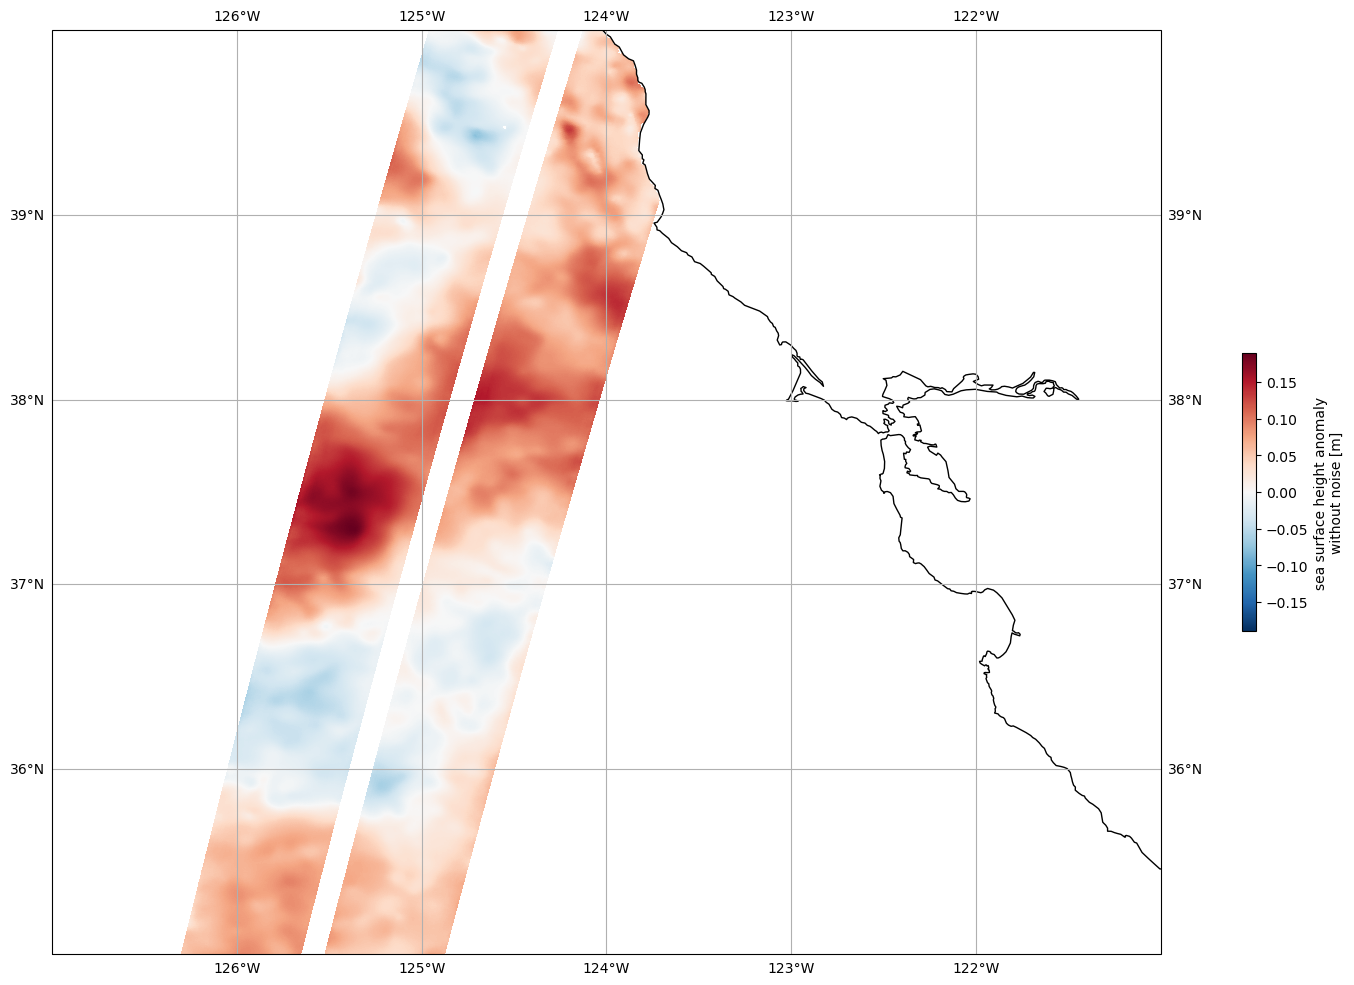

In [16]:
plot_kwargs = dict(
    x="longitude",
    y="latitude",
)

fig, ax = plt.subplots(figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ds.ssha_noiseless.plot.pcolormesh(ax=ax, cbar_kwargs={"shrink": 0.3}, **plot_kwargs)

ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent([-127, -121, 35, 40], crs=ccrs.PlateCarree())